In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
from src.env import *
from src.imports import *
from src.config import *
from src.dataset import *
from src.metric import *

Found cached dataset generator (C:/tempjeka/cache/huggingface/generator/default-f628ff2f2d994b84/0.0.0)
Loading cached split indices for dataset at C:\tempjeka\cache\huggingface\generator\default-f628ff2f2d994b84\0.0.0\cache-a84cfc0a0e11ed54.arrow and C:\tempjeka\cache\huggingface\generator\default-f628ff2f2d994b84\0.0.0\cache-665145fe0a5a6a51.arrow
Loading cached split indices for dataset at C:\tempjeka\cache\huggingface\generator\default-f628ff2f2d994b84\0.0.0\cache-e104a2bffe25c7fa.arrow and C:\tempjeka\cache\huggingface\generator\default-f628ff2f2d994b84\0.0.0\cache-4096519e2393e19f.arrow


<IPython.core.display.Javascript object>

In [3]:
enc_name = "google/mt5-small"
model_name = "mt5_small_multitask"

<IPython.core.display.Javascript object>

In [4]:
tokenizer = AutoTokenizer.from_pretrained(enc_name)

C:\tempjeka\anaconda3\lib\site-packages\transformers\convert_slow_tokenizer.py:454: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


<IPython.core.display.Javascript object>

In [5]:
from datasets import concatenate_datasets


def set_target_eng(batch):
    for row in batch["translation"]:
        row["target_lang"] = "English"
        row["source_lang"] = "Russian"
        row["English"] = row.pop("en")
        row["Russian"] = row.pop("ru")
    return batch


def set_target_ru(batch):
    for row in batch["translation"]:
        row["target_lang"] = "Russian"
        row["source_lang"] = "English"
        row["English"] = row.pop("en")
        row["Russian"] = row.pop("ru")
    return batch


part1_dataset = Dataset.from_generator(
    dataset_convert_csv, cache_dir=os.environ["HF_DATASETS_CACHE"]
)
part1_dataset = part1_dataset.map(set_target_eng, batched=True, batch_size=batch_size)
part2_dataset = Dataset.from_generator(
    dataset_convert_csv, cache_dir=os.environ["HF_DATASETS_CACHE"]
)
part2_dataset = part2_dataset.map(set_target_ru, batched=True, batch_size=batch_size)

def split_dataset(dataset):
    test = dataset.train_test_split(0.1, seed=0)
    val = test["test"].train_test_split(0.99, seed=0)
    return dict(train=test["train"], val=val["train"], test=val["test"])


part1 = split_dataset(part1_dataset)
part2 = split_dataset(part2_dataset)
concatenated_dataset = dict(
    train=concatenate_datasets((part1["train"], part2["train"])),
    val=concatenate_datasets((part1["val"], part2["val"])),
    test=concatenate_datasets((part1["test"], part2["test"])),
)


def create_dataset(tokenizer: AutoTokenizer | None = None) -> Dataset:
    def preprocess_function(batch):
        inputs = tokenizer(
            [
                (
                    f"translate {ex['source_lang']} to {ex['target_lang']}: "
                    + ex[ex["source_lang"]]
                ).strip()
                for ex in batch["translation"]
            ]
        )
        outputs = tokenizer(
            [ex[ex["target_lang"]].strip() for ex in batch["translation"]]
        )

        batch["input_ids"] = inputs.input_ids
        batch["attention_mask"] = inputs.attention_mask
        batch["labels"] = outputs.input_ids.copy()

        batch["input_ids_length"] = [len(row) for row in batch["input_ids"]]
        batch["labels_length"] = [len(row) for row in batch["labels"]]

        return batch

    dataset = DatasetDict(concatenated_dataset).map(
        preprocess_function, batched=True, batch_size=batch_size
    )
    dataset.set_format(
        type="torch",
        columns=["input_ids", "attention_mask", "labels"],
    )
    return dataset

Found cached dataset generator (C:/tempjeka/cache/huggingface/generator/default-530bff6ddf69a109/0.0.0)
Loading cached processed dataset at C:\tempjeka\cache\huggingface\generator\default-530bff6ddf69a109\0.0.0\cache-0f4032964aba6282.arrow
Found cached dataset generator (C:/tempjeka/cache/huggingface/generator/default-530bff6ddf69a109/0.0.0)
Loading cached processed dataset at C:\tempjeka\cache\huggingface\generator\default-530bff6ddf69a109\0.0.0\cache-6491f911007844af.arrow
Loading cached split indices for dataset at C:\tempjeka\cache\huggingface\generator\default-530bff6ddf69a109\0.0.0\cache-a7417e9e17b8e652.arrow and C:\tempjeka\cache\huggingface\generator\default-530bff6ddf69a109\0.0.0\cache-014b2f4fff081585.arrow
Loading cached split indices for dataset at C:\tempjeka\cache\huggingface\generator\default-530bff6ddf69a109\0.0.0\cache-820f511a42ec3fd3.arrow and C:\tempjeka\cache\huggingface\generator\default-530bff6ddf69a109\0.0.0\cache-85fb8fed2649d81d.arrow
Loading cached split ind

<IPython.core.display.Javascript object>

In [6]:
dataset = create_dataset(tokenizer).sort("input_ids_length")

Map:   0%|          | 0/90000 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/9900 [00:00<?, ? examples/s]

<IPython.core.display.Javascript object>

In [7]:
tokenizer.batch_decode(dataset["train"][51330:51340]["labels"])

['В ресторане этого апарт-отеля ежедневно сервируют завтрак, а поблизости от него находятся разнообразные рестораны.</s>',
 'Центр города Райт находится в 5 минутах ходьбы от гостевого дома, который находится непосредственно на лыжном склоне.</s>',
 'В числе удобств изысканно оформленных номеров кабельное телевидение, принадлежности для чая/кофе и мини-холодильник.</s>',
 'К услугам гостей современного отеля типа «постель и завтрак», расположенного в загородной местности, открытый плавательный бассейн и хорошо оборудованная кухня.</s>',
 'Каждый день с 10:00 до 20:00 работает оздоровительный спа-центр с сауной и турецкой баней.</s>',
 'В числе удобств гостевого дома Romaguera общая кухня.</s>',
 'Guests can have a relaxing barbecue by the pool, or lounge on the terrace overlooking the garden.</s>',
 'Billiards and darts are available for guest entertainment, and business facilities are provided.</s>',
 'All accommodation features a well-equipped kitchen or kitchenette.</s>',
 'During s

<IPython.core.display.Javascript object>

In [9]:
part1["val"][0], part2["val"][0]

({'translation': {'English': 'Free WiFi is featured throughout the property.',
   'Russian': 'На всей территории подключен бесплатный Wi-Fi.\n',
   'source_lang': 'Russian',
   'target_lang': 'English'}},
 {'translation': {'English': 'Free WiFi is featured throughout the property.',
   'Russian': 'На всей территории подключен бесплатный Wi-Fi.\n',
   'source_lang': 'English',
   'target_lang': 'Russian'}})

<IPython.core.display.Javascript object>

In [10]:
model = AutoModelForSeq2SeqLM.from_pretrained(enc_name)

<IPython.core.display.Javascript object>

In [11]:
model.config.max_length = max_input_length
model.config.min_length = 10
model.config.no_repeat_ngram_size = 3
model.config.early_stopping = True
model.config.num_beams = 10

<IPython.core.display.Javascript object>

In [12]:
version = 2

<IPython.core.display.Javascript object>

In [13]:
version += 1
args = Seq2SeqTrainingArguments(
    output_dir=Path("models") / model_name,
    evaluation_strategy="steps",
    learning_rate=5e-5,
    #     lr_scheduler_type="constant_with_warmup",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=1,
    num_train_epochs=4,
    predict_with_generate=True,
    warmup_steps=3000,
    fp16=False,
    logging_dir=f"../made/logs/lightning_logs/{model_name}/{version}",
    logging_first_step=False,
    eval_steps=1000,
    logging_steps=500,
    overwrite_output_dir=True,
    group_by_length=True,
)

<IPython.core.display.Javascript object>

In [14]:
trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    compute_metrics=partial(compute_metrics, tokenizer, metric),
    train_dataset=dataset["train"],
    eval_dataset=dataset["val"],
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
)

<IPython.core.display.Javascript object>

In [ ]:
trainer.train()

C:\tempjeka\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Bleu,Gen Len
1000,15.818700,5.710825,0.013690,51.950000
2000,4.466300,2.278508,0.027006,50.240000
3000,3.266300,1.888404,0.043935,59.580000
4000,2.821100,1.711197,0.078820,62.400000
5000,2.555400,1.624669,0.116278,65.130000
6000,2.430600,1.535547,0.134998,68.250000
7000,2.303400,1.468963,0.139088,64.720000
8000,2.231800,1.396612,0.172062,71.020000
9000,2.133100,1.361709,0.160453,67.380000
10000,2.053800,1.329129,0.196267,70.620000


C:\tempjeka\anaconda3\lib\site-packages\transformers\generation\utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 

In [16]:
model.save_pretrained(model_name)

<IPython.core.display.Javascript object>

In [7]:
model = EncoderDecoderModel.from_pretrained(model_name)

<IPython.core.display.Javascript object>

In [17]:
def compute_metrics_test(model, collator, tokenizer, metric, batch, log=False):
    data = collator(dict(input_ids=batch["input_ids"]))

    preds = model.generate(
        data["input_ids"].cuda(),
        attention_mask=data["attention_mask"].cuda(),
    ).cpu()
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    source = [s[s['source_lang']] for s in batch["translation"]]
    decoded_labels = [s[s['target_lang']] for s in batch["translation"]]
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    metric.add_batch(references=decoded_labels, predictions=decoded_preds)
    if log:
        display(
            [
                dict(input=i, target=l, preds=p)
                for p, l, i in zip(decoded_preds, decoded_labels, source)
            ]
        )


<IPython.core.display.Javascript object>

In [25]:
ru_part_test = DatasetDict(dict(test=part2["test"])).map(
    preprocess_function, batched=True, batch_size=batch_size
)
ru_part_test.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"],
)

Map:   0%|          | 0/4950 [00:00<?, ? examples/s]

<IPython.core.display.Javascript object>

In [26]:
metric = evaluate.load("bleu")
model.cuda()
model.eval()
with torch.no_grad():
    ru_part_test["test"].map(
        partial(
            compute_metrics_test,
            model,
            DataCollatorWithPadding(tokenizer),
            tokenizer,
            metric,
            log=False,
        ),
        batched=True,
        batch_size=batch_size,
    )

Map:   0%|          | 0/4950 [00:00<?, ? examples/s]

<IPython.core.display.Javascript object>

In [28]:
metric.compute()

{'bleu': 0.29851986983150725,
 'precisions': [0.5917859274680798,
  0.3811287007546637,
  0.27385306275196897,
  0.19709493471032932],
 'brevity_penalty': 0.8987024077003947,
 'length_ratio': 0.9035028872841114,
 'translation_length': 68687,
 'reference_length': 76023}

<IPython.core.display.Javascript object>

In [20]:
metric = evaluate.load("bleu")
model.cuda()
model.eval()
_idx = 100
with torch.no_grad():
    dataset["test"].select(range(_idx, _idx + 16)).map(
        partial(
            compute_metrics_test,
            model,
            DataCollatorWithPadding(tokenizer),
            tokenizer,
            metric,
            log=True,
        ),
        batched=True,
        batch_size=batch_size,
    )
metric.compute()

Map:   0%|          | 0/16 [00:00<?, ? examples/s]

C:\tempjeka\anaconda3\lib\site-packages\transformers\generation\utils.py:1313: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'input': 'Internet is free at the hotel.',
  'target': ['В отеле предоставляется бесплатный доступ в интернет.'],
  'preds': 'На территории отеля предоставляется бесплатный Wi-Fi.'},
 {'input': 'The property offers free parking.',
  'target': ['В распоряжении гостей бесплатная парковка.'],
  'preds': 'На территории обустроена бесплатная парковка.'},
 {'input': 'The property offers free parking.',
  'target': ['Предоставляется бесплатная парковка.'],
  'preds': 'На территории обустроена бесплатная парковка.'},
 {'input': 'Breakfast is served every morning.',
  'target': ['Каждое утро для гостей сервируется завтрак.'],
  'preds': 'Каждое утро для гостей сервируется завтрак.'}]

[{'input': 'The property offers free parking.',
  'target': ['На территории обустроена бесплатная парковка.'],
  'preds': 'На территории обустроена бесплатная парковка.'},
 {'input': 'Room service options are also available.',
  'target': ['Кроме того, производится доставка еды и напитков в номер.'],
  'preds': 'Гости могут воспользоваться услугами доставки еды и напитков в номер.'},
 {'input': 'The property offers free parking.',
  'target': ['Гостям предоставляется место на бесплатной парковки.'],
  'preds': 'На территории обустроена бесплатная парковка.'},
 {'input': 'The property offers free parking.',
  'target': ['Места на парковке дома для отпуска предоставляются бесплатно.'],
  'preds': 'На территории обустроена бесплатная парковка.'}]

[{'input': 'It features free Wi-Fi.',
  'target': ['К услугам гостей бесплатный WiFi.'],
  'preds': 'К услугам гостей бесплатный Wi-Fi.'},
 {'input': 'Barbecue facilities are also available.',
  'target': ['Предоставляются принадлежности для барбекю.'],
  'preds': 'В распоряжении гостей принадлежности для барбекю.'},
 {'input': 'On-site parking is free.',
  'target': ['На территории отеля предоставляется бесплатная парковка.'],
  'preds': 'На территории обустроена бесплатная парковка.'},
 {'input': 'Free secure parking is available.',
  'target': ['Для гостей предусмотрена бесплатная охраняемая парковка.'],
  'preds': 'На территории обустроена бесплатная охраняемая парковка.'}]

[{'input': 'It provides free private parking.',
  'target': ['К услугам гостей бесплатная частная парковка.'],
  'preds': 'К услугам гостей бесплатная частная парковка.'},
 {'input': 'The property offers free parking.',
  'target': ['На территории виллы обустроена бесплатная парковка.'],
  'preds': 'На территории обустроена бесплатная парковка.'},
 {'input': 'Some have a balcony.',
  'target': ['Некоторые апартаменты оборудованы балконом.'],
  'preds': 'В некоторых номерах есть балкон.'},
 {'input': 'The property offers free parking.',
  'target': ['Гостям предоставляется бесплатная парковка.'],
  'preds': 'На территории обустроена бесплатная парковка.'}]

{'bleu': 0.43901642391210577,
 'precisions': [0.6132075471698113,
  0.5,
  0.40540540540540543,
  0.3103448275862069],
 'brevity_penalty': 0.9906103979507198,
 'length_ratio': 0.9906542056074766,
 'translation_length': 106,
 'reference_length': 107}

<IPython.core.display.Javascript object>

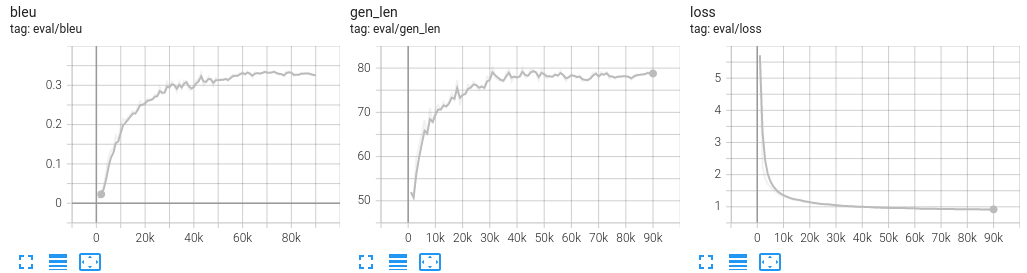 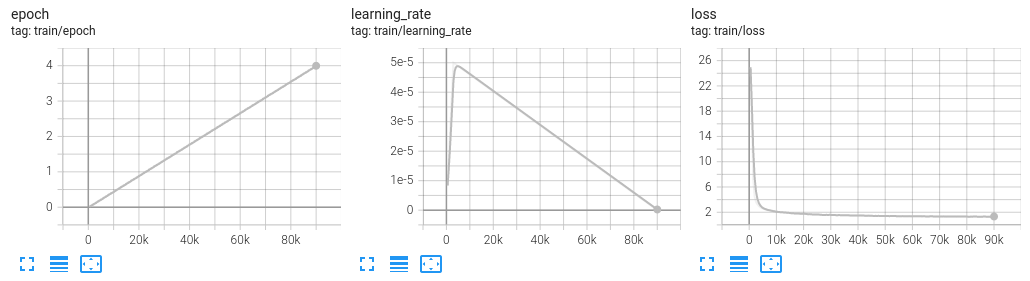